In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.metrics import jaccard_score
import math

/home/jeetendra/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeetendra/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeetendra/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeetendra/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
REL_IMAGE_PATH = "../data/images-256/"
REL_MASK_PATH = "../data/masks-256/"
TEST_IMAGE_PATH = os.path.join(REL_IMAGE_PATH, 'test')
TEST_MASK_PATH = os.path.join(REL_MASK_PATH, 'test')
image_names = os.listdir(TEST_IMAGE_PATH)

In [3]:
width = 256
height = 256
channel = 3

In [4]:
def jaccard_distance(y_true, y_pred, smooth=100):
    #""" Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [5]:
#creating U-Net architecture
def create_model(width, height, channel):
    inputs = tf.keras.layers.Input((width,height,channel))
    s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c5)


    u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6,c4])
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7,c3])
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8,c2])
    c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9,c1],axis = 3)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c9)

    outputs = tf.keras.layers.Conv2D(1,(1,1),activation = "sigmoid")(c9)

    model = tf.keras.Model(inputs = [inputs],outputs = [outputs])
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    #model.summary()
    return model

In [12]:
#creating U-Net architecture
def create_model(width, height, channel, loss, metric):
    inputs = tf.keras.layers.Input((width,height,channel))
    s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c5)


    u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6,c4])
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7,c3])
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8,c2])
    c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9,c1],axis = 3)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c9)

    outputs = tf.keras.layers.Conv2D(1,(1,1),activation = "sigmoid")(c9)

    model = tf.keras.Model(inputs = [inputs],outputs = [outputs])
    model.compile(optimizer = 'adam',loss = loss, metrics = [metric])
    #model.summary()
    return model

In [14]:
model = create_model(256, 256, 3, 'cosine_similarity', 'accuracy')

In [15]:
model.load_weights("./cosine_similarity_256x256-03.hdf5")

In [16]:
def round_image(image, threshold):
    flat_img = image.flatten()
    flat_img_round = [0 if v <= threshold  else 1 for v in flat_img]
    round_img = np.reshape(flat_img_round, image.shape)
    return round_img

In [17]:
image_name = image_names[random.randint(0, len(image_names))]
image_path = os.path.join(TEST_IMAGE_PATH, image_name)
img = Image.open(image_path)
new_img = img.resize((width,height))
np_img = np.array(new_img)
np_img = np_img[...,:3]


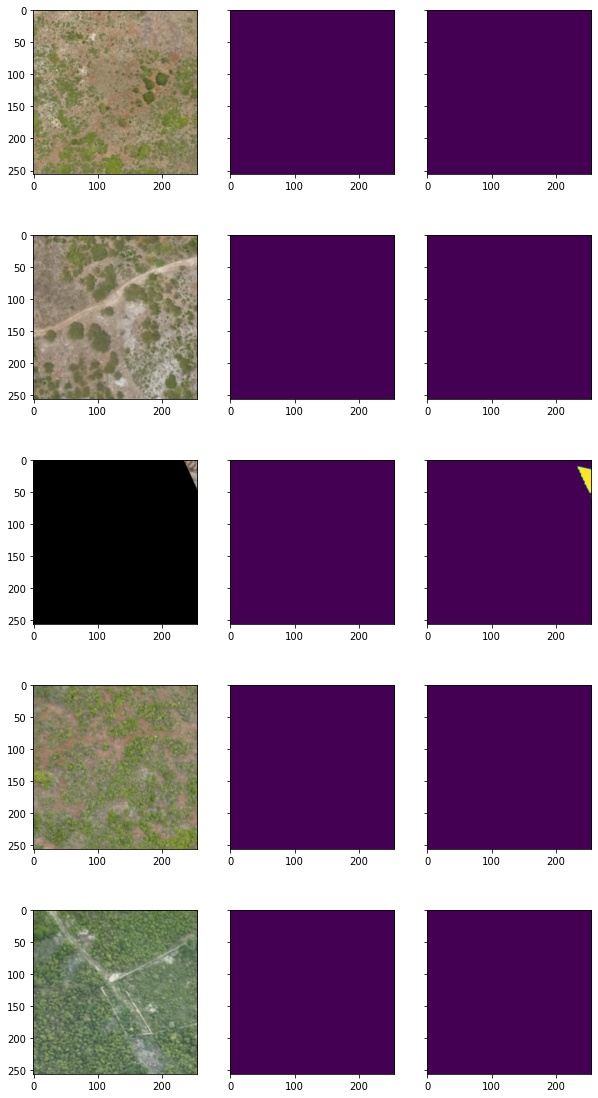

In [21]:
#def predict_and_show_random_images(model, n, width, height, channel):
n = 5
fig, ax = plt.subplots(n, 3, sharey='row', figsize = (2*n,4*n))

images_to_predict = np.zeros((n,width,height,channel),dtype = np.uint8)
masks = []

for i in range(n):
    image_name = image_names[random.randint(0, len(image_names))]
    image_path = os.path.join(TEST_IMAGE_PATH, image_name)
    img = Image.open(image_path)
    new_img = img.resize((width,height))
    np_img = np.array(new_img)
    np_img = np_img[...,:3]
    images_to_predict[i] = np_img

    mask_path = os.path.join(TEST_MASK_PATH, image_name[:-4]+"_mask.png")
    mask = Image.open(mask_path)
    mask = mask.resize((width, height))
    masks.append(mask)


results = model.predict(images_to_predict)
predictions = []
i = 0
for result in results:
    result_i = np.squeeze(result)
    predictions.append(result_i)

    # show orignal image
    ax[i, 0].imshow(images_to_predict[i])

    # show the prediction
    ax[i, 1].imshow(round_image(predictions[i], 0.2))

    # show the mask
    ax[i, 2].imshow(masks[i])
    i += 1
        
#return {'orignal_images': images_to_predict, 'predictions': predictions}

In [53]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

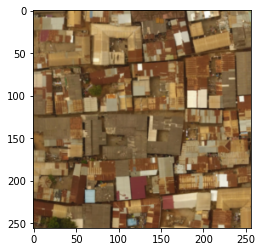

In [83]:
image_name = image_names[random.randint(0, len(image_names))]
image_path = os.path.join(TEST_IMAGE_PATH, image_name)
img = plt.imread(image_path)
plt.imshow(img)

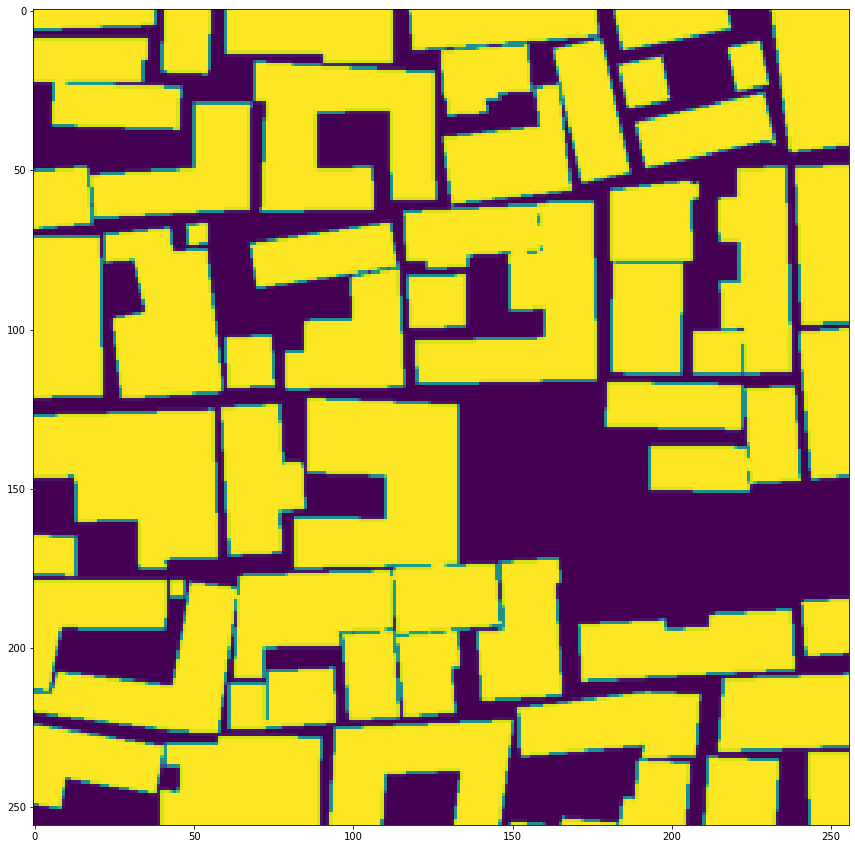

In [92]:
msk_path = os.path.join(REL_MASK_PATH, image_name[:-4]+"_mask.png")
mask = plt.imread(msk_path)
fig = plt.figure()
fig.set_size_inches(15,15)
plt.imshow(mask)

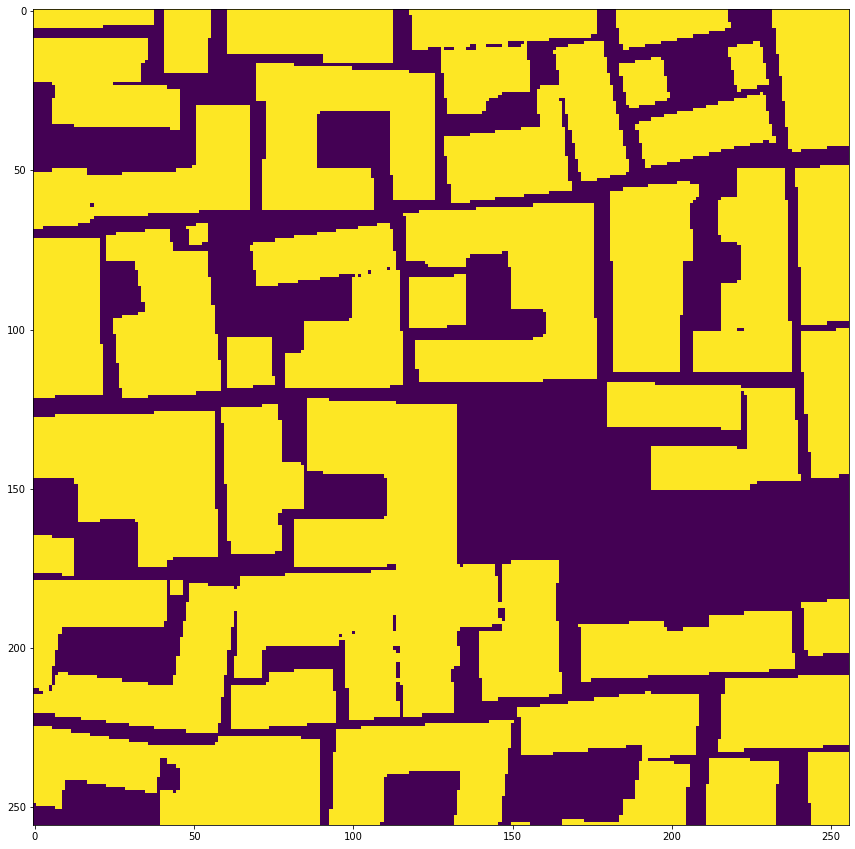

In [93]:
fig = plt.figure()
fig.set_size_inches(15,15)
plt.imshow(round_image(mask, 0.5))

In [174]:
np.unique(mask.flatten())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1])

In [173]:
mask_np = np.array(masks[0])
mask_np

array([[  0,   0,   0, ...,  69,  12,   0],
       [  0,   0,   0, ..., 246, 232,  62],
       [  0,   0,   0, ..., 254, 241,  19],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

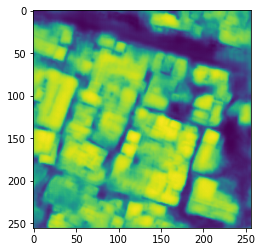

In [177]:
plt.imshow(predictions[0])

In [183]:
actual = masks[0]
actual = np.array(actual).flatten()
pred = predictions[0]
pred = np.array(pred).flatten()
pred = pred * 255
pred = np.floor(pred).astype(int)
pred_img = pred.reshape((256, 256))
actual_img = actual.reshape((256, 256))

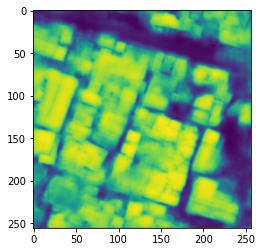

In [181]:
plt.imshow(pred_img)

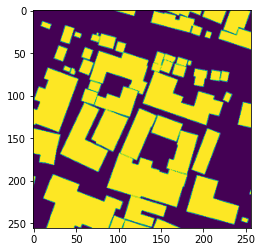

In [184]:
plt.imshow(actual_img)

In [206]:
zero_img = np.zeros(256*256)

In [230]:
jaccard_score(actual, zero_img, average = "micro")

0.28985022338562066

In [231]:
jaccard_score(actual, pred, average = "micro")

0.00010682293335775

In [139]:
pred

array([36, 36, 33, ..., 83, 85, 91])

In [145]:
actual

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

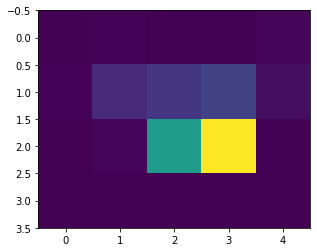

In [154]:
i1 = np.array([[1,2,0,0,4], [2,30,40,50,9], [0, 3, 140, 255, 0], [0, 0, 0, 0, 0]])
plt.imshow(i1)

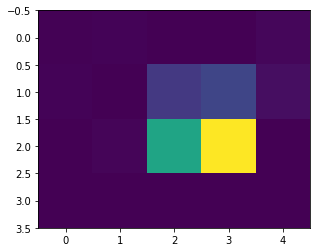

In [161]:
i2 = np.array([[1,2,0,0,4], [2,0,40,50,9], [0, 3, 140, 240, 0], [0, 0, 0, 0, 0]])
plt.imshow(i2)

In [229]:
jaccard_score(i1.flatten(), i2.flatten(), average = "micro")

0.8181818181818182

In [159]:
#y_true = np.array([[0, 1, 1], [1, 1, 0]])
#y_pred = np.array([[1, 1, 1], [1, 0, 0]])
#actual = masks[0]
#pred = predictions[0]
jaccard_score(actual, pred, average = "micro")

0.00010682293335775

In [81]:
y_true = masks[0]
y_pred = predictions[0]
smooth = 100

In [163]:
y_true = [0, 1, 1, 1, 1, 0]
y_pred = [0, 1, 1, 1, 1, 0]

In [217]:
intersection = tf.reduce_sum(y_true * y_pred)

TypeError: can't multiply sequence by non-int of type 'list'

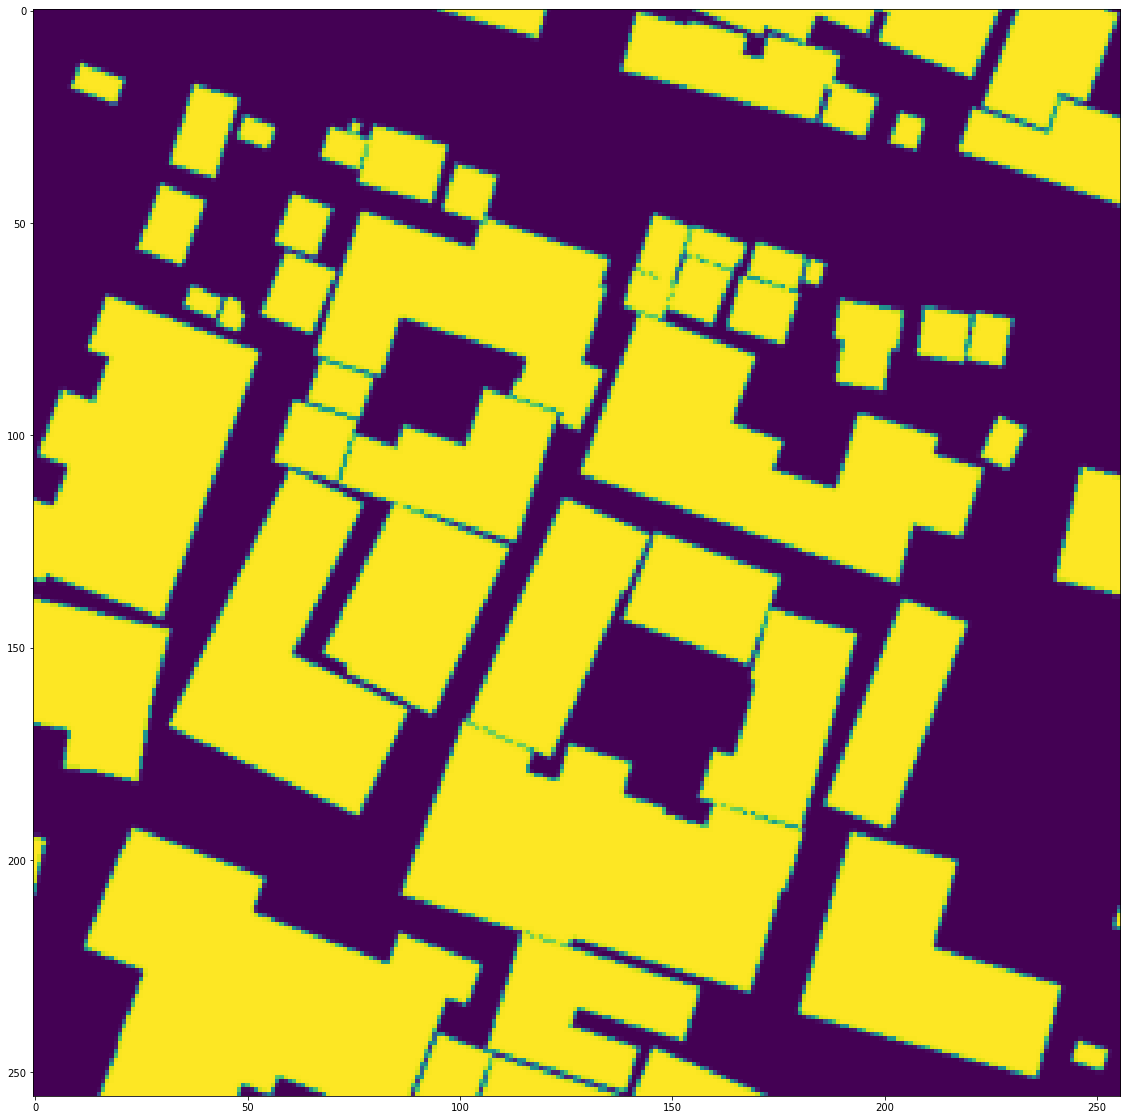

In [74]:
fig = plt.figure()
fig.set_size_inches(20,20)
plt.imshow(masks[0])

In [76]:
y_true = np.array(y_true)
np.unique(y_true.flatten())

array([  0,   1,   5,   6,   7,  11,  12,  13,  14,  18,  19,  20,  24,
        25,  26,  27,  31,  32,  33,  38,  39,  56,  57,  62,  63,  64,
        68,  69,  70,  75,  76,  81,  82,  83,  88,  89, 113, 114, 119,
       120, 121, 125, 126, 127, 132, 133, 134, 138, 139, 140, 145, 146,
       151, 152, 170, 171, 176, 177, 178, 182, 183, 184, 189, 190, 191,
       194, 196, 197, 201, 202, 203, 220, 221, 226, 227, 228, 232, 233,
       234, 235, 239, 240, 241, 242, 245, 246, 247, 248, 252, 253, 254,
       255], dtype=uint8)

In [ ]:
sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))

In [ ]:
jac = (intersection + smooth) / (sum_ - intersection + smooth)

In [ ]:
jd =  (1 - jac) * smooth

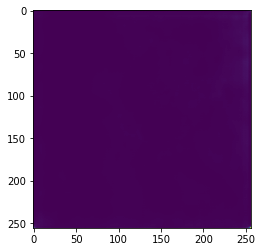

In [35]:
plt.imshow(res['predictions'][6])

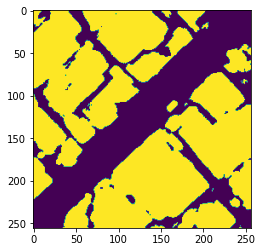

In [29]:
plt.imshow(round_image(res['predictions'][6], 0.5))

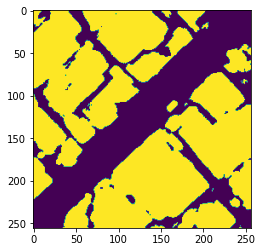

In [13]:
res['predictions'][6]

array([[0.56191266, 0.5981915 , 0.5894629 , ..., 0.43171275, 0.44953945,
        0.4291178 ],
       [0.6226511 , 0.629826  , 0.6226963 , ..., 0.4061436 , 0.41374806,
        0.37861258],
       [0.63595307, 0.6586361 , 0.66125727, ..., 0.35465473, 0.37499523,
        0.3607005 ],
       ...,
       [0.08296156, 0.08762592, 0.0760203 , ..., 0.30845535, 0.28614527,
        0.2898069 ],
       [0.11259365, 0.09595853, 0.09044531, ..., 0.349681  , 0.33122596,
        0.3368402 ],
       [0.18184498, 0.12968731, 0.11459422, ..., 0.39898205, 0.3868389 ,
        0.3812418 ]], dtype=float32)

In [37]:
im = res['predictions'][5] * 255

In [33]:
res['predictions'][5]

array([0.32577023, 0.25012204, 0.17696726, 0.12982771, 0.10371053,
       0.08914223, 0.08995938, 0.09787747, 0.12218791, 0.14762595,
       0.2014865 , 0.22273254, 0.28729975, 0.33021474, 0.46596244,
       0.5752549 , 0.6799877 , 0.62982196, 0.5683298 , 0.55356014,
       0.6463777 , 0.70817024, 0.79197073, 0.8351252 , 0.8467591 ,
       0.8571538 , 0.83600163, 0.83844674, 0.8436991 , 0.8483299 ,
       0.8339977 , 0.697648  , 0.5121098 , 0.38935128, 0.30904302,
       0.24115133, 0.24766663, 0.18371826, 0.1765266 , 0.14962855,
       0.16083813, 0.13910434, 0.13057041, 0.1318928 , 0.13811582,
       0.14081857, 0.157969  , 0.1592274 , 0.14722654, 0.12644553,
       0.11917496, 0.11416572, 0.11711684, 0.1168907 , 0.13991654,
       0.14782849, 0.18574637, 0.20128983, 0.2128891 , 0.17565888,
       0.17046157, 0.14530903, 0.15204293, 0.1301179 , 0.12303841,
       0.11028165, 0.09663841, 0.08659056, 0.08892086, 0.09407932,
       0.09367293, 0.08548838, 0.0871318 , 0.08005363, 0.08419

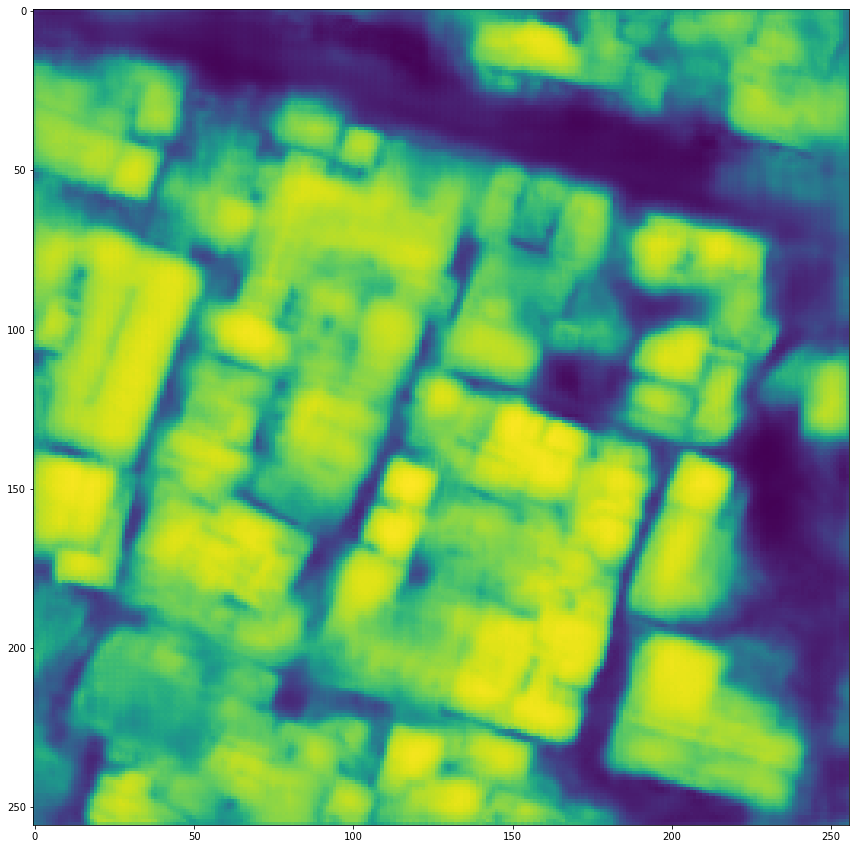

In [223]:
fig = plt.figure()
fig.set_size_inches(15,15)
plt.imshow(pred_img)

In [23]:
i = cv2.imwrite('temp.png', res['predictions'][5])

In [24]:
img = cv2.imread('temp.png', cv2.IMREAD_GRAYSCALE)

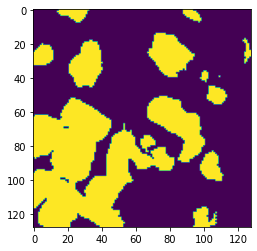

In [25]:
plt.imshow(img)

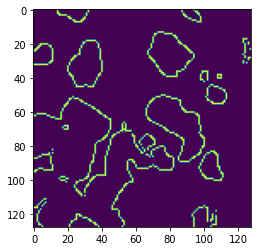

In [26]:
canny = cv2.Canny(img, 0, 1)
plt.imshow(canny)

In [34]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

In [48]:
im = cv2.filter2D(img, -1, kernel)

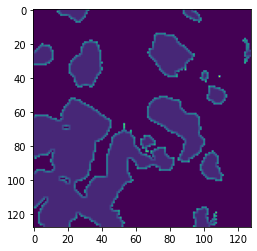

In [49]:
plt.imshow(im)

In [53]:
im.flatten().unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [46]:
im.astype(np.uint8)

array([[111, 231, 210, ...,  35,  47, 127],
       [218, 108,  89, ..., 243, 232,  42],
       [233, 132,  94, ...,  20,   0,  26],
       ...,
       [106, 245, 193, ...,   6, 255,   4],
       [153,  21,  49, ...,  10, 238,  15],
       [149,  84,  30, ...,  13,  11,  71]], dtype=uint8)

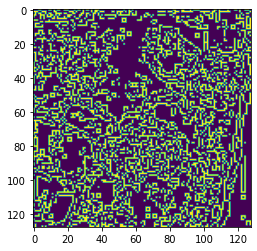

In [45]:
canny2 = cv2.Canny(im.astype(np.uint8), 220, 250)
plt.imshow(canny2)